https://physionet.org/content/butqdb/1.0.0/#files-panel

In [ ]:
# import some libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from google.colab import drive
from scipy.signal import resample, find_peaks
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report
import os
import gc

In [ ]:
# download library WFDB to manage dataset
!pip install wfdb
import wfdb
from wfdb import processing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.1 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive', force_remount=True)
dataset_path = "/content/drive/MyDrive/APPUNTI_LEZIONI/AIA - Applicazioni di IA/progetto/datasets/BUT-QDB-1.0.0"

Mounted at /content/drive


In [ ]:
def remove_not_annotated(annotator):

    # remove rows where annotation label == 0
    annotator.drop(annotator[annotator['ann'] == 0].index, inplace = True)

    # Drop the rows where at least one element is missing.
    annotator = annotator.dropna()

    return annotator

In [ ]:
directories = [dir.name for dir in os.scandir(dataset_path) if dir.is_dir()]

####################### CHANGE THIS FROM 0 TO 17 ##############################
patient = directories[0]
# DATA INTENSIVE INDEXES: 0, 6, 7
###############################################################################

# load ECG signal
path_folder = dataset_path + "/" + patient + '/'
data_ecg = wfdb.rdrecord(path_folder + patient + "_ECG")
print('RECORD INFO: ', data_ecg.__dict__)

# CONSUMA LA RAM !!!!!
# plot entire signal
#wfdb.plot_wfdb(data_ecg)

# extract useful information
ecg_signal = data_ecg.p_signal
ecg_sf = data_ecg.fs
ecg_baseline = data_ecg.baseline
ecg_units = data_ecg.units # ['uV']

# Free unused RAM
del data_ecg
gc.collect()

RECORD INFO:  {'record_name': '100001_ECG', 'n_sig': 1, 'fs': 1000, 'counter_freq': None, 'base_counter': None, 'sig_len': 87087000, 'base_time': None, 'base_date': None, 'comments': ['ECG'], 'sig_name': ['ECG'], 'p_signal': array([[ 2.22905812e+04],
       [ 2.22795591e+04],
       [ 2.22805611e+04],
       ...,
       [-1.30260521e+01],
       [-2.30460922e+01],
       [-2.30460922e+01]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['100001_ECG.dat'], 'fmt': ['16'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [1.996], 'baseline': [-12200], 'units': ['uV'], 'adc_res': [0], 'adc_zero': [0], 'init_value': [32292], 'checksum': [1186], 'block_size': [0]}


0

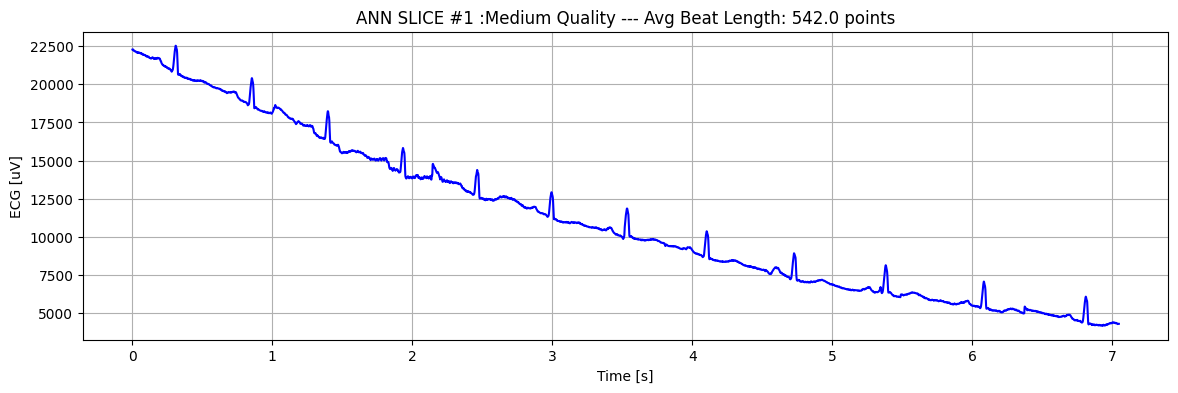

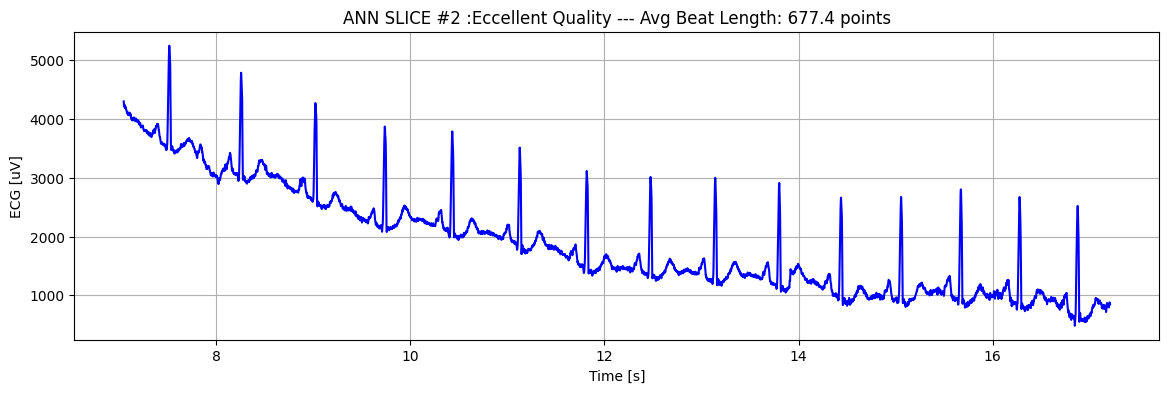

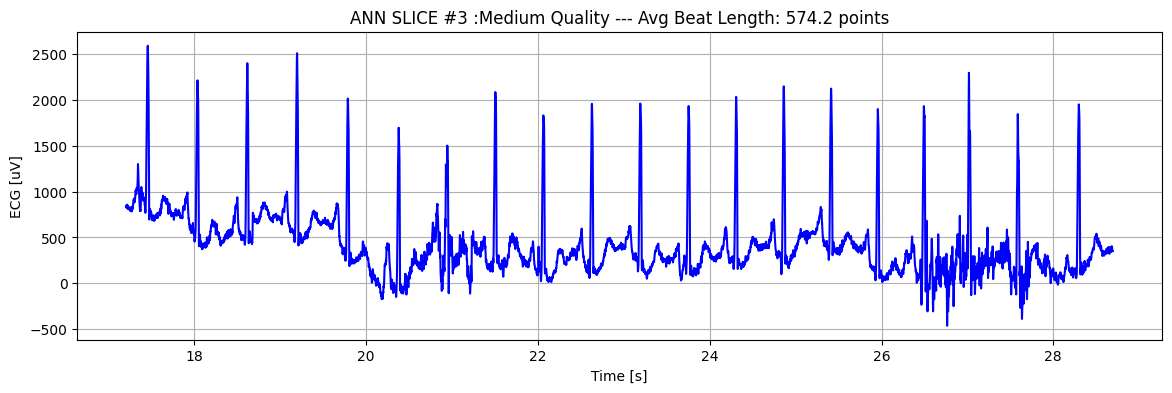

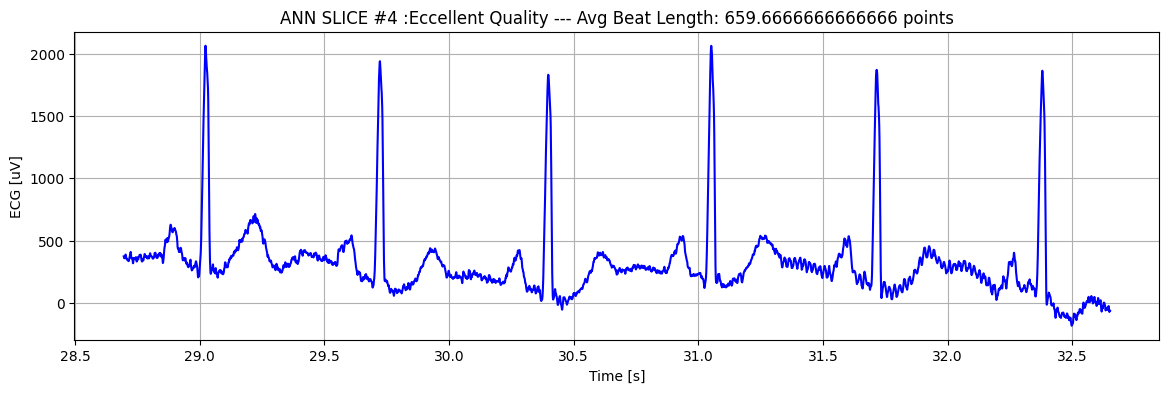

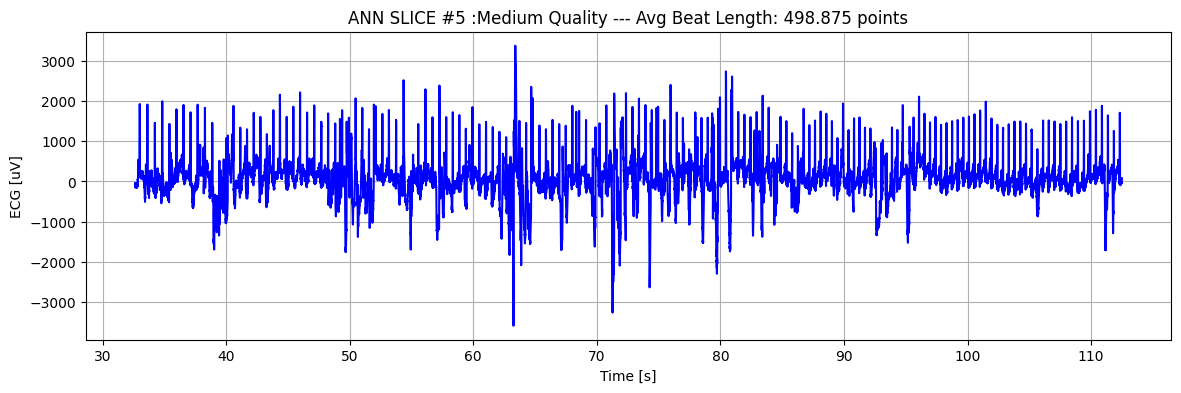

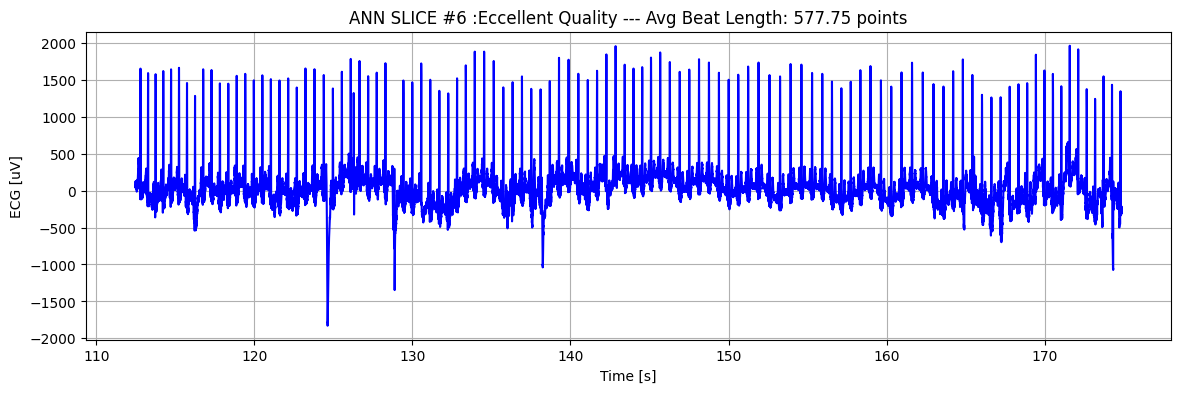

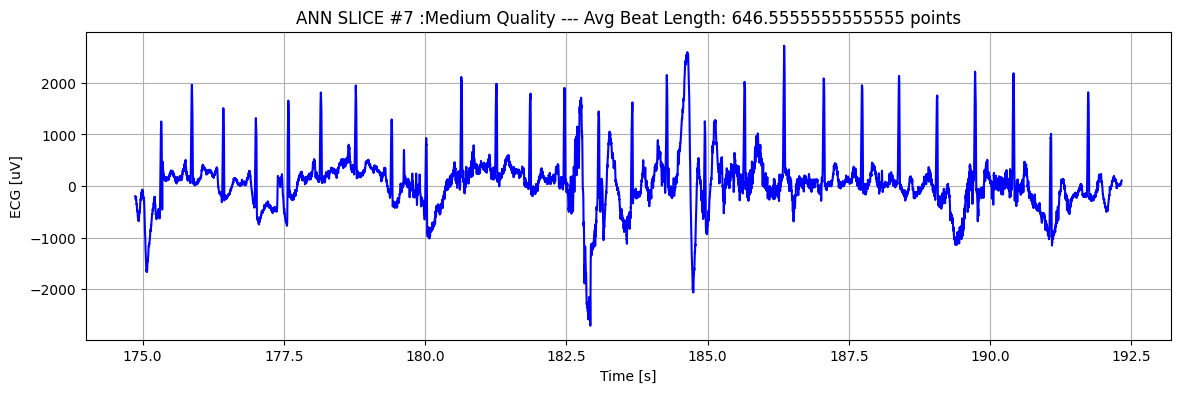

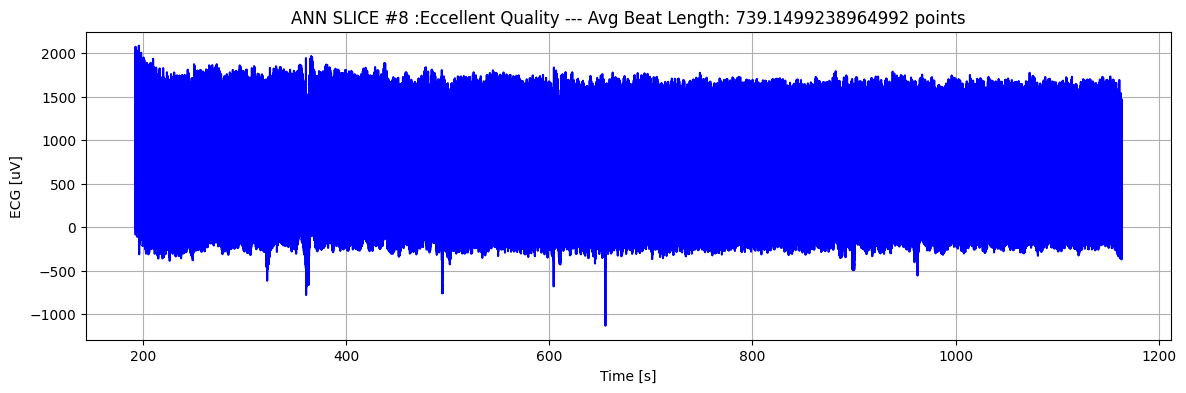

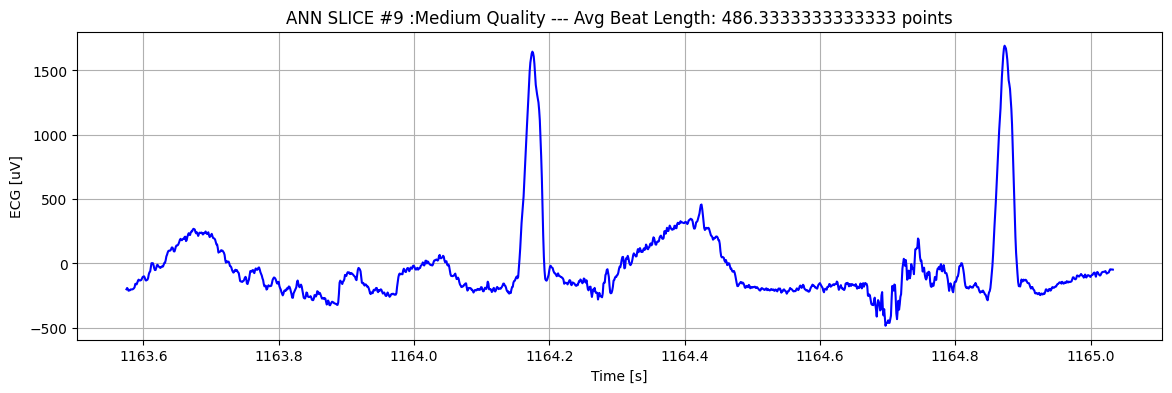

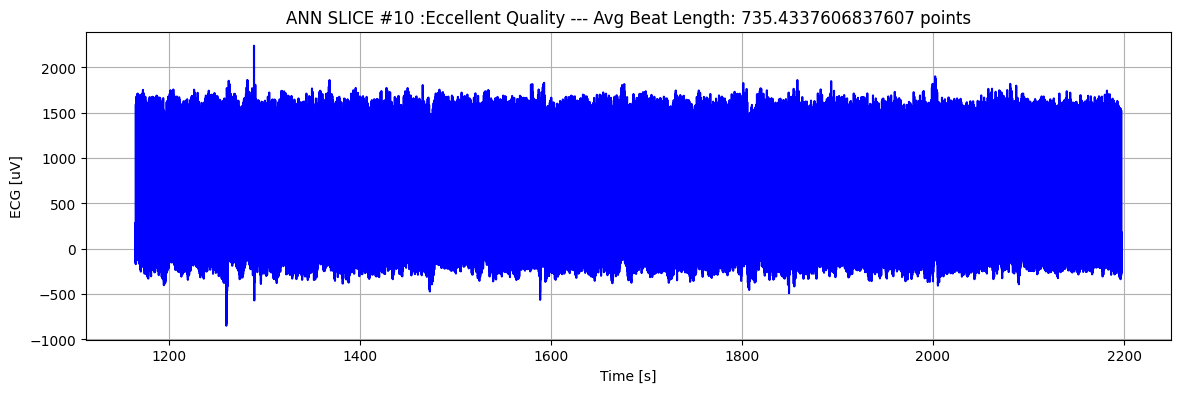

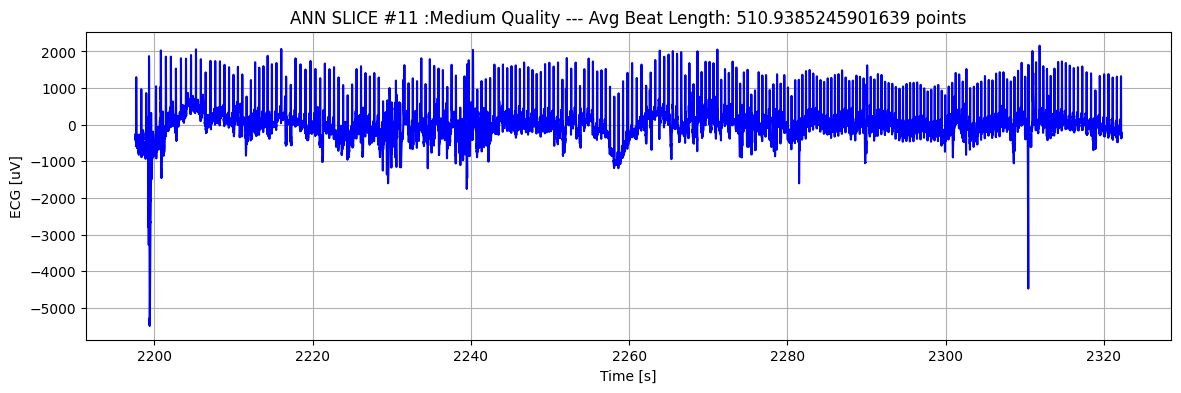

In [ ]:
labels_map ={1 : 'Eccellent Quality', 2 : 'Medium Quality', 3 : 'Bad Quality', 0 : 'Not annotated'}

# dataset preprocessing

col_names = ['start1', 'end1', 'ann1', 'start2', 'end2', 'ann2', 'start3', 'end3', 'ann3', 'start', 'end', 'ann']

#annotator = remove_not_annotated(pd.read_csv(path_folder + patient + "_ANN.csv", names=col_names, header=None)[['start', 'end', 'ann']])
annotator = pd.read_csv(path_folder + patient + "_ANN.csv", names=col_names, header=None)[['start', 'end', 'ann']]

start_ann = annotator['start']
end_ann = annotator['end']
labels_ann = annotator['ann']

time_ecg = np.arange(len(ecg_signal)) / ecg_sf

for index, (start, end, ann) in enumerate(zip(start_ann, end_ann, labels_ann)):

    # calculate n. of R peaks for estimate avg beat length
    qrs_inds = processing.xqrs_detect(ecg_signal[int(start) : int(end)].flatten(), fs=ecg_sf, verbose=False)
    n_r_peaks = len(qrs_inds)
    n_signal_samples = len(ecg_signal[int(start) : int(end)])

    # plot some beats
    plt.figure(figsize=(14, 4))
    plt.plot(time_ecg[int(start) : int(end)], ecg_signal[int(start) : int(end)], color='b')
    # lunghezza del segnale / n picchi R => lunghezza media battito
    plt.title('ANN SLICE #' + str(index + 1) +' :' + str(labels_map[int(ann)]) + ' --- Avg Beat Length: ' + str( n_signal_samples / n_r_peaks) + ' points')
    plt.xlabel('Time [s]')
    plt.ylabel(f'ECG [{ecg_units[0]}]')
    plt.grid()
    plt.savefig('/content/plot_slices_p' + str(patient) +'_n' + str(index + 1) + '.png')
    plt.show()

    if index == 10:
      break

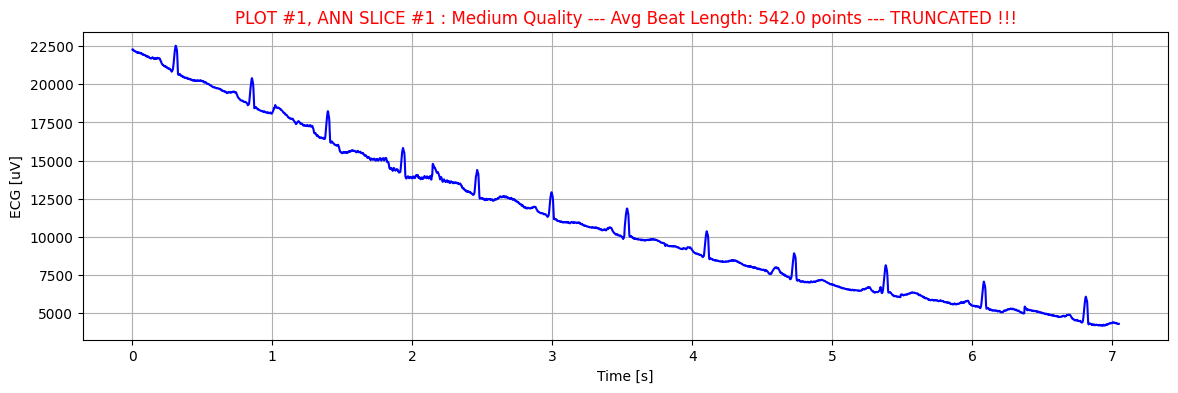

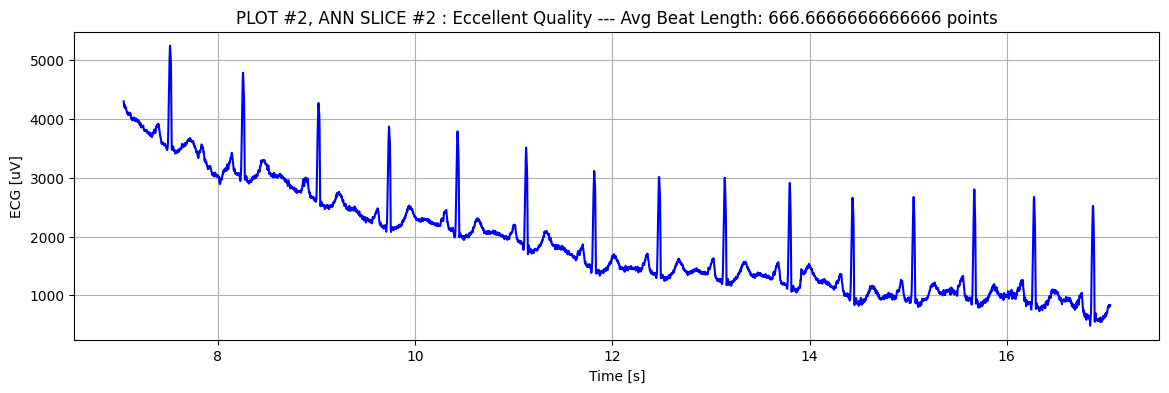

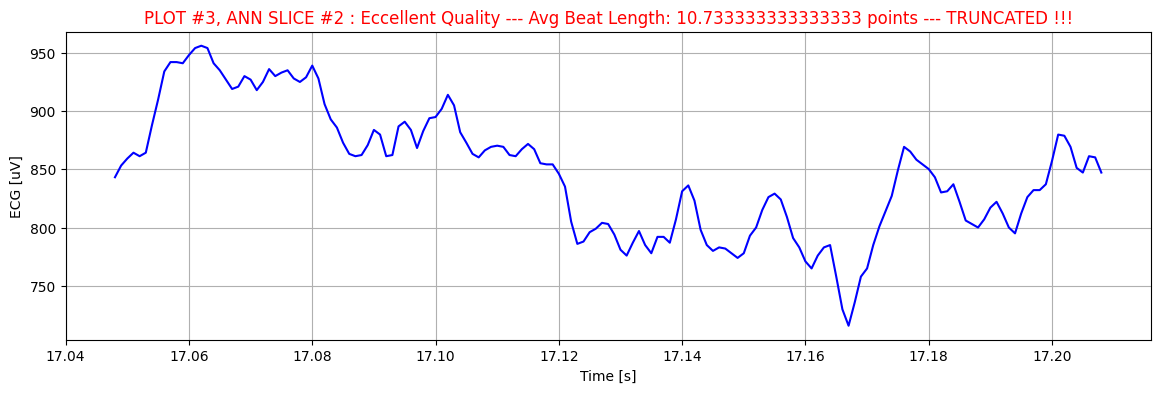

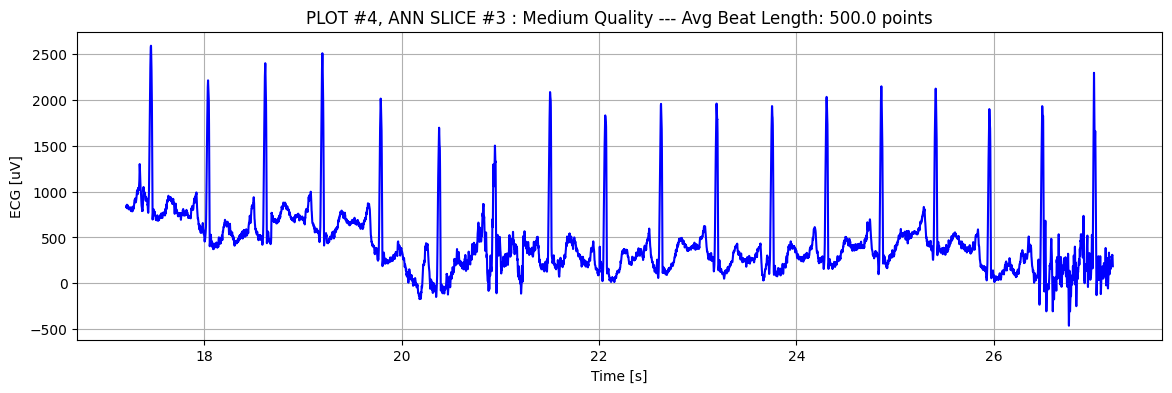

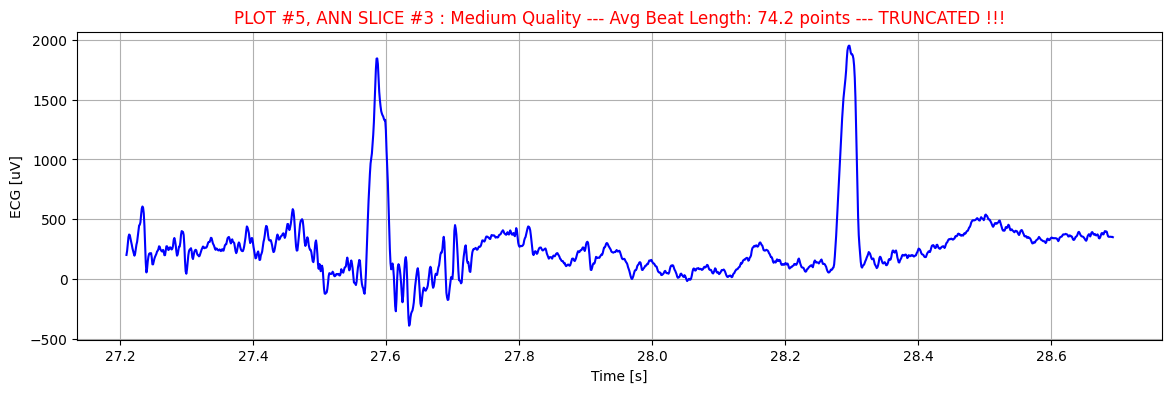

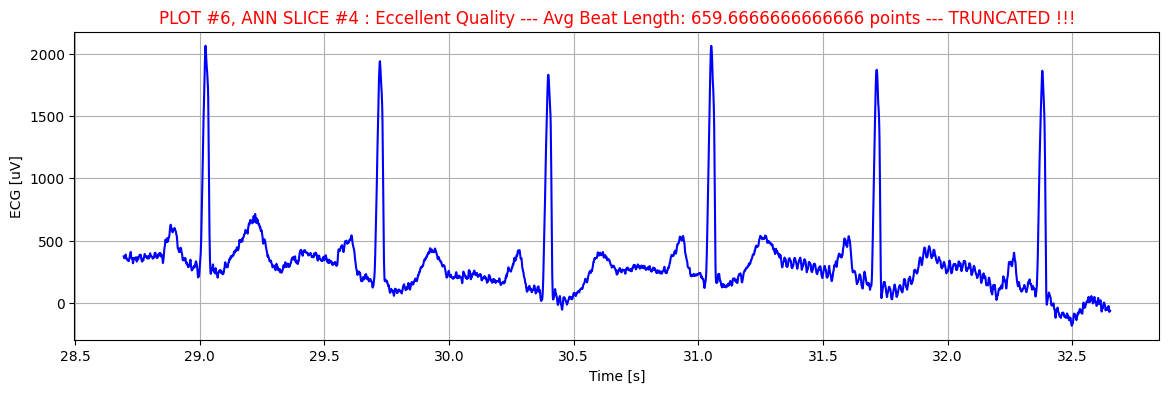

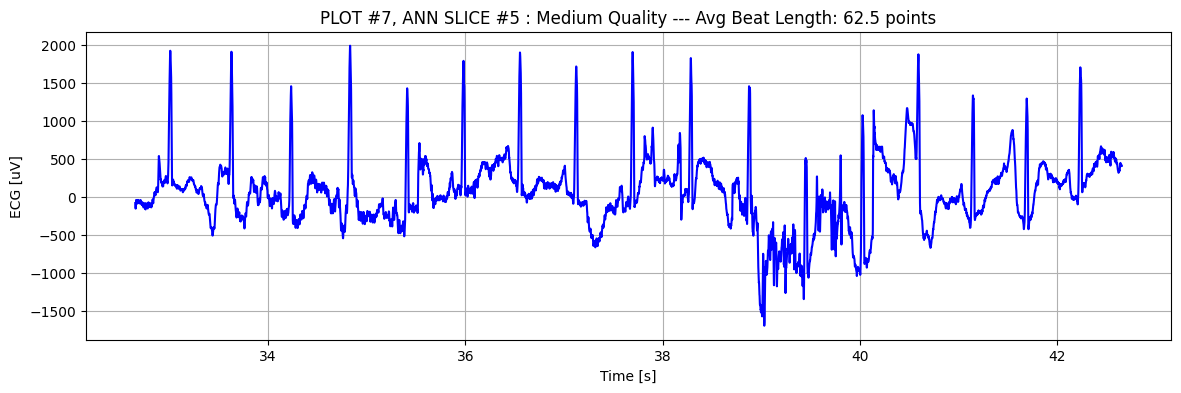

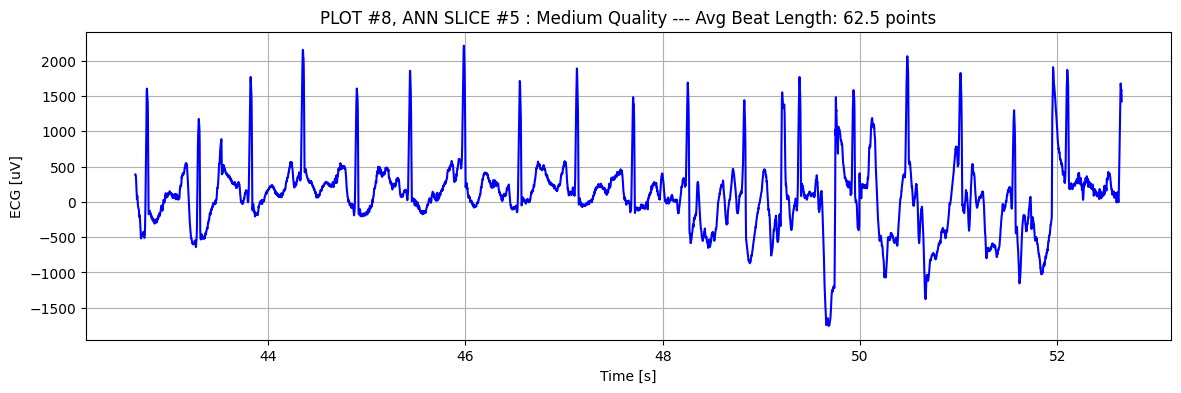

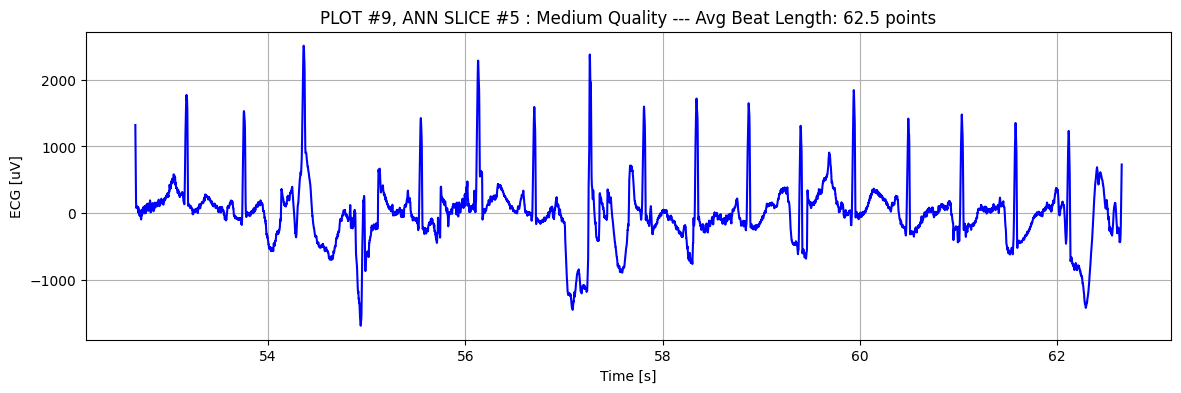

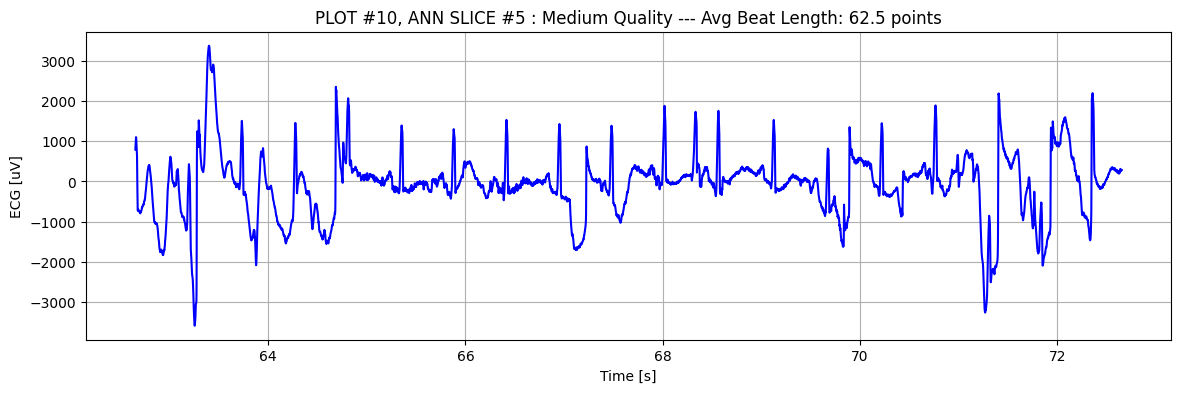

In [ ]:
labels_map ={1 : 'Eccellent Quality', 2 : 'Medium Quality', 3 : 'Bad Quality', 0 : 'Not annotated'}

# dataset preprocessing

col_names = ['start1', 'end1', 'ann1', 'start2', 'end2', 'ann2', 'start3', 'end3', 'ann3', 'start', 'end', 'ann']

#annotator = remove_not_annotated(pd.read_csv(path_folder + patient + "_ANN.csv", names=col_names, header=None)[['start', 'end', 'ann']])
annotator = pd.read_csv(path_folder + patient + "_ANN.csv", names=col_names, header=None)[['start', 'end', 'ann']]

start_ann = annotator['start']
end_ann = annotator['end']
labels_ann = annotator['ann']

time_ecg = np.arange(len(ecg_signal)) / ecg_sf

# Contatore per tracciare il numero di grafici generati
plot_count = 0
############################# CHANGE THIS
max_plots = 10
############################# CONSTANT STEP SIZE
step_size = 10*ecg_sf # 10 sec

for index_out, (start, end, ann) in enumerate(zip(start_ann, end_ann, labels_ann)):

    # renaming ECG segment and time
    segment = ecg_signal[int(start) : int(end)]
    time_segment = time_ecg[int(start) : int(end)]

    # Utilizzare un ciclo for con range e passo per scorrere il segmento
    for window_start in range(0, len(segment), step_size):

        if plot_count >= max_plots:
            break

        window_end = window_start + step_size
        if window_end > len(segment):
            window_end = len(segment)

        # Calcolo n. di picchi R per stimare la lunghezza media del battito
        qrs_inds = processing.xqrs_detect(segment.flatten(), fs=ecg_sf, verbose=False)
        n_r_peaks = len(qrs_inds)
        n_signal_samples = len(segment[window_start : window_end])

        # Plot di alcune finestre
        plt.figure(figsize=(14, 4))
        plt.plot(time_segment[window_start : window_end], segment[window_start : window_end], color='b')

        # lunghezza del segnale / n picchi R => lunghezza media battito
        # change title if the plot is truncated
        if window_end == len(segment):
          plt.title(f'PLOT #{plot_count + 1}, ANN SLICE #{index_out + 1} : {labels_map[int(ann)]} --- Avg Beat Length: {n_signal_samples / n_r_peaks if n_r_peaks > 0 else "No Peak found"} points --- TRUNCATED !!!', color = 'r')
        else:
          plt.title(f'PLOT #{plot_count + 1}, ANN SLICE #{index_out + 1} : {labels_map[int(ann)]} --- Avg Beat Length: {n_signal_samples / n_r_peaks if n_r_peaks > 0 else "No Peak found"} points', color = 'k')


        plt.xlabel('Time [s]')
        plt.ylabel(f'ECG [{ecg_units[0]}]')
        plt.grid()
        plt.savefig('/content/plot_windows_p' + str(patient) +'_plt' + str(plot_count + 1) + '_slice' + str(index_out + 1) + '_points.png')
        plt.show()

        plot_count += 1
        if plot_count >= max_plots:
            break

        # Interrompe il ciclo se abbiamo raggiunto la fine del segnale
        if window_end == len(segment):
            #print('The above signal is truncated !!!')
            break

    # plot only a portion of original signal
    if plot_count >= max_plots:
      break

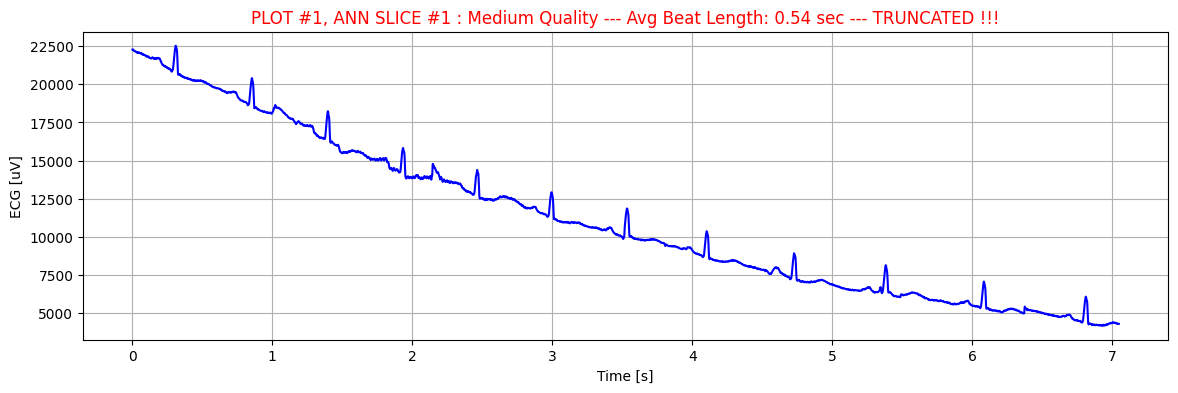

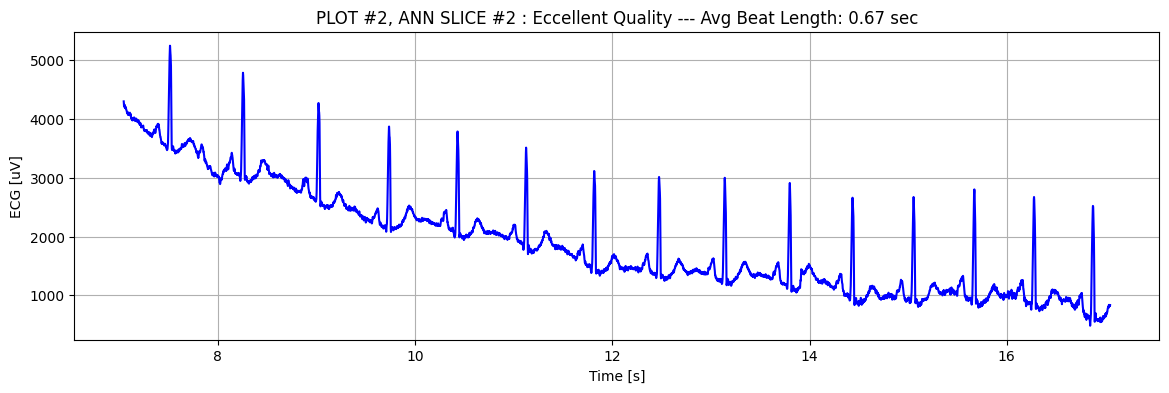

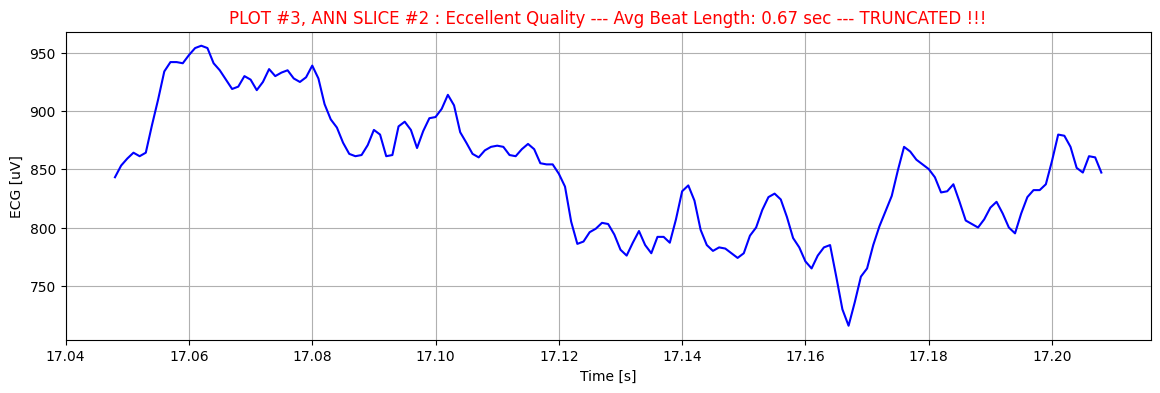

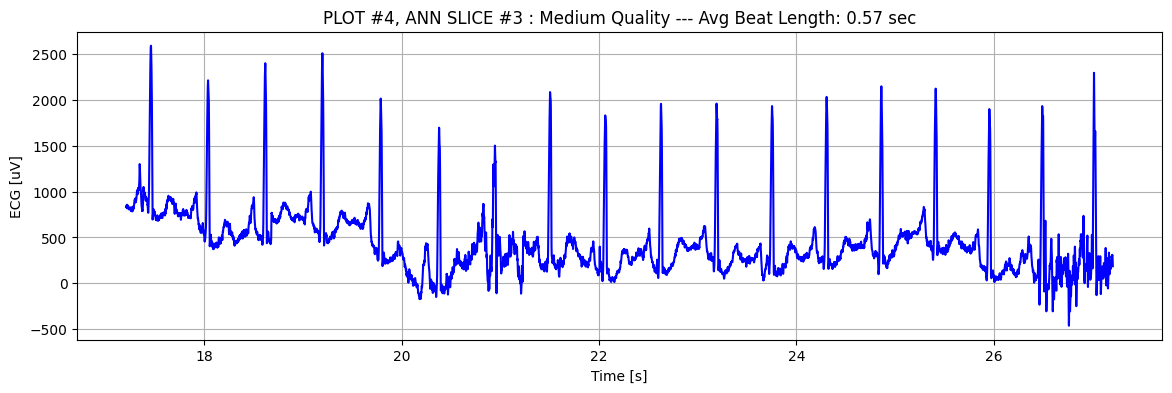

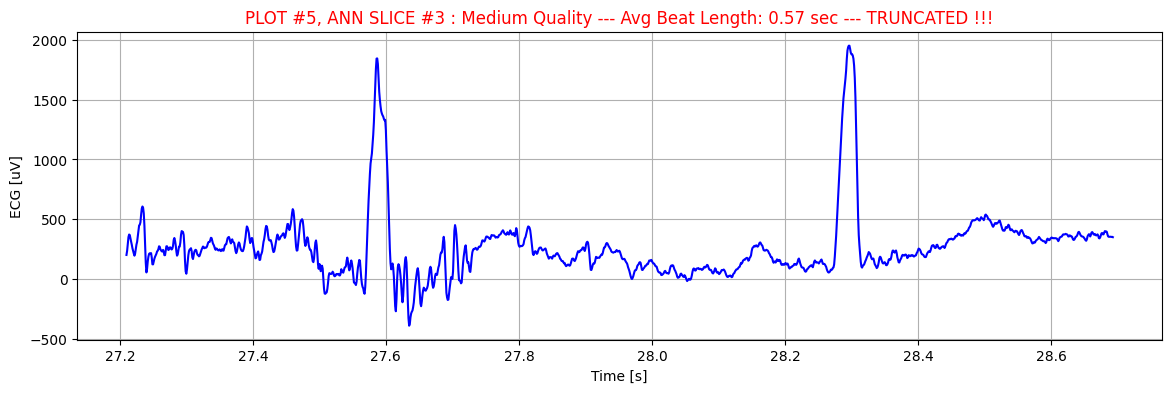

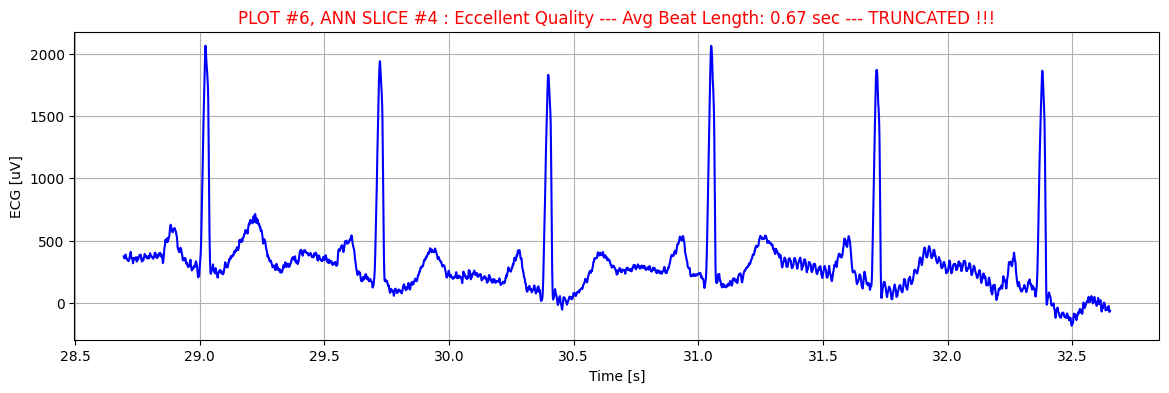

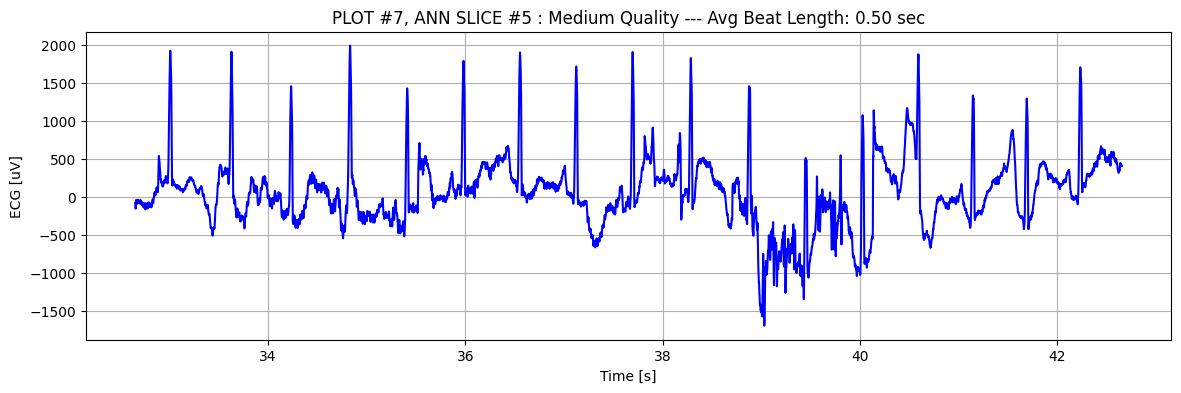

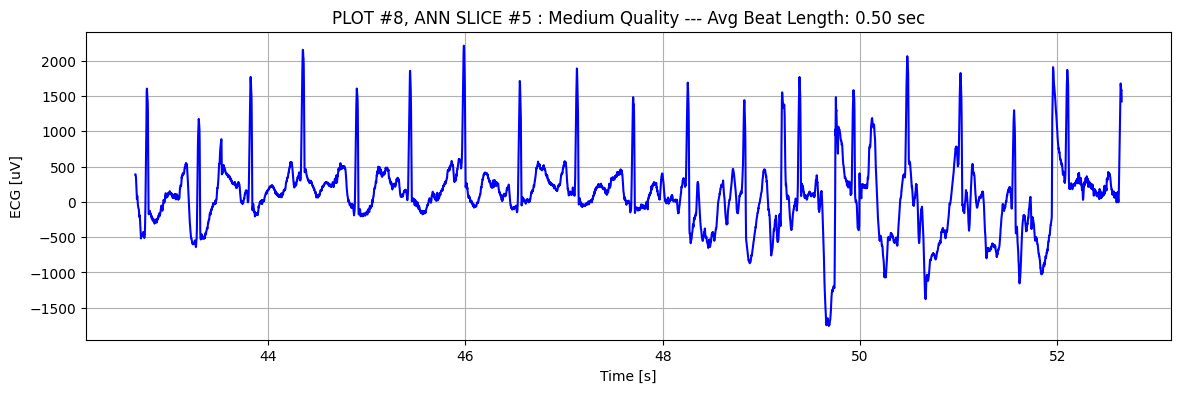

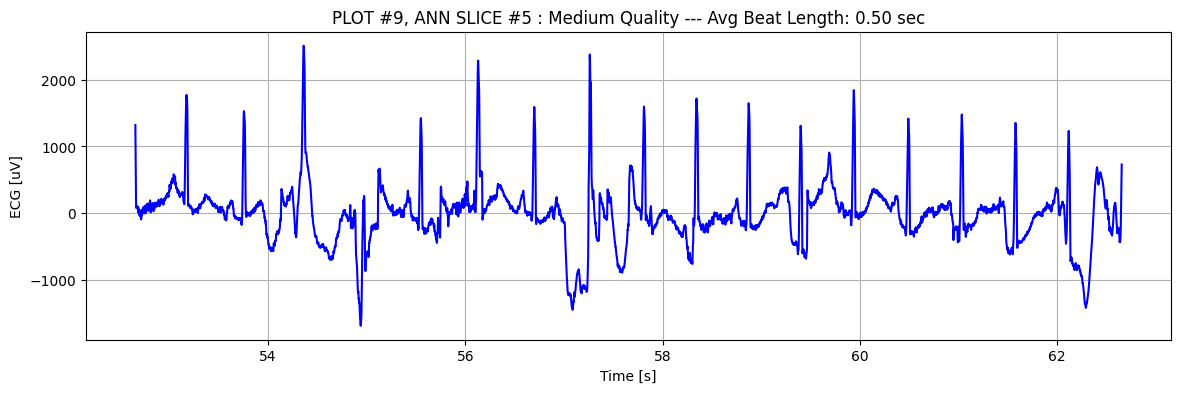

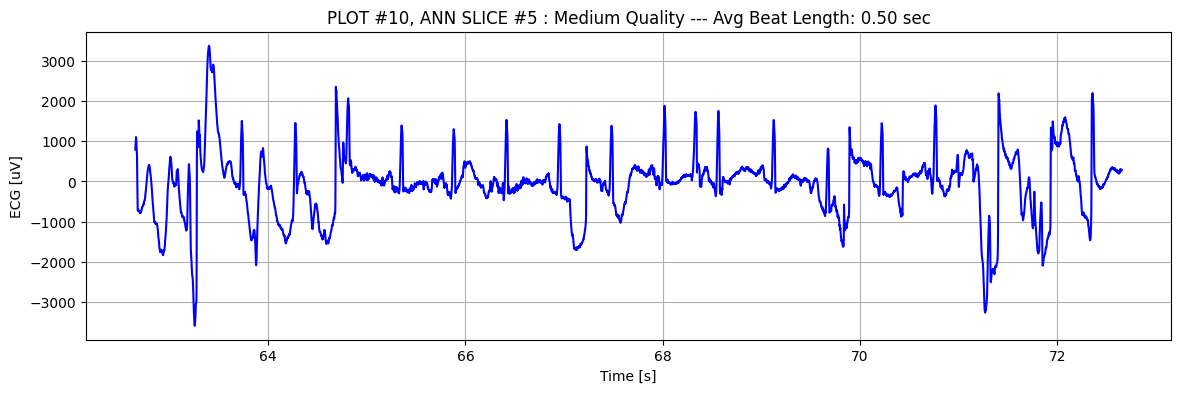

In [ ]:
labels_map ={1 : 'Eccellent Quality', 2 : 'Medium Quality', 3 : 'Bad Quality', 0 : 'Not annotated'}

# dataset preprocessing

col_names = ['start1', 'end1', 'ann1', 'start2', 'end2', 'ann2', 'start3', 'end3', 'ann3', 'start', 'end', 'ann']

#annotator = remove_not_annotated(pd.read_csv(path_folder + patient + "_ANN.csv", names=col_names, header=None)[['start', 'end', 'ann']])
annotator = pd.read_csv(path_folder + patient + "_ANN.csv", names=col_names, header=None)[['start', 'end', 'ann']]

start_ann = annotator['start']
end_ann = annotator['end']
labels_ann = annotator['ann']

time_ecg = np.arange(len(ecg_signal)) / ecg_sf

# Contatore per tracciare il numero di grafici generati
plot_count = 0
############################# CHANGE THIS
max_plots = 10

for index_out, (start, end, ann) in enumerate(zip(start_ann, end_ann, labels_ann)):

    ################################### CONSTANT STEP SIZE
    step_size = 10*ecg_sf

    # renaming ECG segment and time
    segment = ecg_signal[int(start) : int(end)]
    time_segment = time_ecg[int(start) : int(end)]

    # Utilizzare un ciclo for con range e passo per scorrere il segmento
    for window_start in range(0, len(segment), step_size):

        if plot_count >= max_plots:
            break

        window_end = window_start + step_size
        if window_end > len(segment):
            window_end = len(segment)

        # Calcolo n. di picchi R per stimare la lunghezza media del battito
        qrs_inds = processing.xqrs_detect(segment.flatten(), fs=ecg_sf, verbose=False)
        n_r_peaks = len(qrs_inds)
        n_signal_samples = len(segment[window_start : window_end])

        # Calcolare gli intervalli RR per stimare la lunghezza media di un battito
        if len(qrs_inds) > 1:
            # Convertire gli intervalli in secondi
            rr_intervals = np.diff(qrs_inds) / ecg_sf
            avg_beat_duration = np.mean(rr_intervals)
        else:
            avg_beat_duration = 0

        # Plot di alcune finestre
        plt.figure(figsize=(14, 4))
        plt.plot(time_segment[window_start : window_end], segment[window_start : window_end], color='b')

        # lunghezza del segnale / n picchi R => lunghezza media battito
        # change title if the plot is truncated
        if window_end == len(segment):
          plt.title(f'PLOT #{plot_count + 1}, ANN SLICE #{index_out + 1} : {labels_map[int(ann)]} --- Avg Beat Length: {avg_beat_duration:.2f} sec --- TRUNCATED !!!', color = 'r')
        else:
          plt.title(f'PLOT #{plot_count + 1}, ANN SLICE #{index_out + 1} : {labels_map[int(ann)]} --- Avg Beat Length: {avg_beat_duration:.2f} sec', color = 'k')

        plt.xlabel('Time [s]')
        plt.ylabel(f'ECG [{ecg_units[0]}]')
        plt.grid()
        plt.savefig('/content/plot_windows_p' + str(patient) +'_plt' + str(plot_count + 1) + '_slice' + str(index_out + 1) + '_secs.png')
        plt.show()

        plot_count += 1
        if plot_count >= max_plots:
            break

        # Interrompe il ciclo se abbiamo raggiunto la fine del segnale
        if window_end == len(segment):
            #print('The above signal is truncated !!!')
            break

    # plot only a portion of original signal
    if plot_count >= max_plots:
      break